In [1]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn.functional as F
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

As illustrated in the first policy gradient algorithm, REINFORCE, the estimation of action values $q_t\left(s_t, a_t\right)$ should be accurate.

\begin{equation}
\theta_{t+1}=\theta_t+\alpha \nabla_\theta \ln \pi\left(a_t \mid s_t, \theta_t\right) q_t\left(s_t, a_t\right)
\end{equation}

To estimate the action values $q_t\left(s_t, a_t\right)$, apart from the Monte Carlo method used in REINFORCE , we can also use the TD method to estimate them.

In this notebook, we will implement a new algorithm, QAC, which uses the TD method (*Sarsa*) to estimate the action values. Moreover, we will use a neural network (with parameter $w$) to approximate $q_t\left(s_t, a_t\right)$, which is similar to the value function approximation TD algorithms.

\begin{equation}
 w_{t+1}=w_t+\alpha_w\left[r_{t+1}+\gamma q\left(s_{t+1}, a_{t+1}, w_t\right)-\right.\left.q\left(s_t, a_t, w_t\right)\right] \nabla_w q\left(s_t, a_t, w_t\right)
\end{equation}

The function of the $q$ approximator is called the **critic**. Since the policy gradient algorithm returns a policy, it is called the **actor**. Therefore, The policy gradient algorithm with a critic is called **actor-critic** algorithm.

The policy traning process, i.e., the actor, will be the same as the REINFORCE algorithm but the action values will be estimated by the critic:

\begin{equation}
\theta_{t+1}=\theta_t+\alpha_\theta \nabla_\theta \ln \pi\left(a_t \mid s_t, \theta_t\right) q\left(s_t, a_t, w_{t+1}\right)
\end{equation}

In [2]:
class QAC_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    def __init__(self,
                 actor_network:torch.nn, # The policy network
                 critic_network:torch.nn, # The value network
                 actor_optimizer:torch.optim,
                 critic_optimizer:torch.optim, 
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        self.device = device
        self.actor_network = actor_network
        self.critic_network = critic_network
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer
        self.critic_criteria = torch.nn.MSELoss()
        
        self.gamma = gamma
        
    def get_action(self, obs:np.ndarray) -> Tuple[int, torch.tensor]:        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        picked_action = torch.distributions.Categorical(self.actor_network(obs)).sample()  
        picked_action_prob = self.actor_network(obs).gather(0, picked_action)
        log_prob = torch.log(picked_action_prob)
               
        return picked_action.item(), log_prob
    
    def train_sarsa_critic(self,
                           obs:np.ndarray,
                           action:int,
                           reward:float,
                           next_obs:int,
                           next_action:int,
                           terminated:bool
                           ) -> float:
        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        reward = torch.tensor(reward, dtype = torch.float32).to(self.device)
        next_obs = torch.tensor(next_obs, dtype = torch.float32).to(self.device)
        current_Q = self.critic_network(obs)[action]
        TD_target = reward + (1-float(terminated)) * self.gamma * self.critic_network(next_obs)[next_action]
        loss = self.critic_criteria(current_Q,TD_target)
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()
        
        return loss.item()
        
           
    def train_policy(self,
                     obs:np.ndarray,
                     action:int,
                     log_prob:torch.tensor,
                     ) -> float:
        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        loss = -log_prob * self.critic_network(obs)[action]
        self.actor_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()
        
        return loss.item()

In [3]:
class Actor_Network(torch.nn.Module):
    """You can define your own network structure here."""
    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Actor_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,128)
        self.fc2 = torch.nn.Linear(128,action_dim)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=0) # The softmax function is used to convert the output to a probability distribution
        
        return x
    
class Critic_Network(torch.nn.Module):
    """You can define your own network structure here."""
    def __init__(self,obs_dim:int,action_dim) -> None:
        super(Critic_Network,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,64)
        self.fc3 = torch.nn.Linear(64,action_dim)
            
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        return self.fc3(x)

In [4]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 lr:float = 0.001,
                 gamma:float = 0.9
                 ) -> None:
        
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = torch.device("cpu")
        
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n
        actor_network = Actor_Network(obs_dim,action_dim).to(self.device)
        critic_network = Critic_Network(obs_dim,action_dim).to(self.device)        
        actor_optimizer = torch.optim.Adam(actor_network.parameters(),lr=lr)
        critic_optimizer = torch.optim.Adam(critic_network.parameters(),lr=lr)
        self.agent = QAC_Agent(actor_network = actor_network,
                               critic_network = critic_network,
                               actor_optimizer = actor_optimizer,
                               critic_optimizer = critic_optimizer,
                               gamma = gamma,
                               device = self.device)
        
        self.episode_total_rewards = np.zeros(self.episode_num)
        self.step_critic_loss = []
        self.step_actor_loss = []
        self.index_episode = 0 
        
    def train_episode(self,is_render:bool=False) -> float:
        total_reward = 0
        obs,_ = self.env.reset() 
        while True:
            action, log_prob = self.agent.get_action(obs) 
            next_obs, reward, terminated, _, _ = self.env.step(action)
            total_reward += reward 
            next_action,_ = self.agent.get_action(next_obs)
            critic_loss = self.agent.train_sarsa_critic(obs,action,reward,next_obs,next_action,terminated)
            self.step_critic_loss.append(critic_loss)
            actor_loss = self.agent.train_policy(obs,action,log_prob)
            self.step_actor_loss.append(actor_loss)
            
            obs = next_obs
            if is_render:
                self.env.render()
                                
            if terminated:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
            
        return total_reward  
    
    def test_episode(self) -> float:
        total_reward = 0 
        obs,_ = self.env.reset() 
        while True:
            action,_ = self.agent.get_action(obs) 
            _, reward, terminated, _, _= self.env.step(action) 
            total_reward += reward
            self.env.render()
            if terminated: break
            
        return total_reward
    
    def train(self) -> None:      
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
            
            """Here we can add the test function."""
            # if e % 100 == 0: 
            #     test_reward = self.test_episode()
            #     print('Test Total Reward = %.2f'%(test_reward))
    
    def plotting(self,smoothing_window:int = 100) -> None:
        """ Plot the episode reward over time. """
        fig1 = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()
        
        fig2 = plt.figure(figsize=(10,5))
        plt.plot(self.step_critic_loss,label="Step Critic Loss")
        plt.plot(self.step_actor_loss,label="Step Actor Loss")
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title("Step Loss over Time")
        plt.legend()
        plt.show()
        
        

c:\Users\gemin\miniconda3\envs\pytorch\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Episode 0: Total Reward = 36.00
Episode 1: Total Reward = 10.00
Episode 2: Total Reward = 11.00
Episode 3: Total Reward = 18.00
Episode 4: Total Reward = 13.00
Episode 5: Total Reward = 10.00
Episode 6: Total Reward = 11.00
Episode 7: Total Reward = 10.00
Episode 8: Total Reward = 12.00
Episode 9: Total Reward = 9.00
Episode 10: Total Reward = 13.00
Episode 11: Total Reward = 10.00
Episode 12: Total Reward = 9.00
Episode 13: Total Reward = 9.00
Episode 14: Total Reward = 9.00
Episode 15: Total Reward = 12.00
Episode 16: Total Reward = 9.00
Episode 17: Total Reward = 9.00
Episode 18: Total Reward = 10.00
Episode 19: Total Reward = 13.00
Episode 20: Total Reward = 10.00
Episode 21: Total Reward = 10.00
Episode 22: Total Reward = 10.00
Episode 23: Total Reward = 9.00
Episode 24: Total Reward = 11.00
Episode 25: Total Reward = 10.00
Episode 26: Total Reward = 9.00
Episode 27: Total Reward = 10.00
Episode 28: Total Reward = 11.00
Episode 29: Total Reward = 9.00
Episode 30: Total Reward = 8.

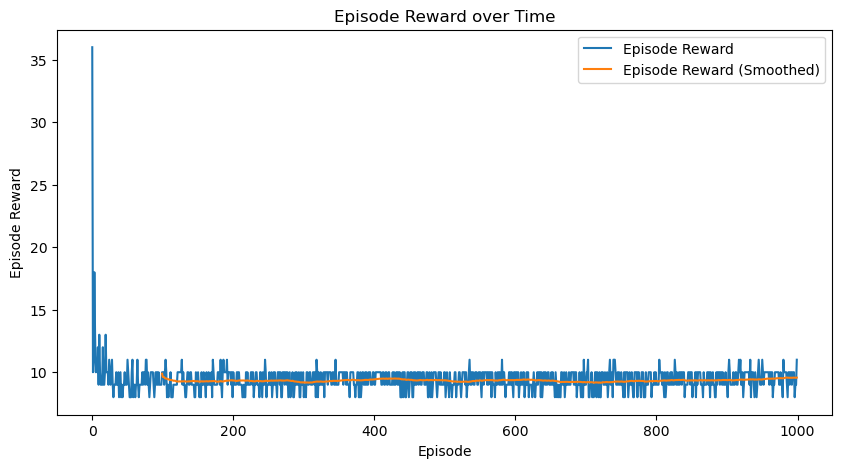

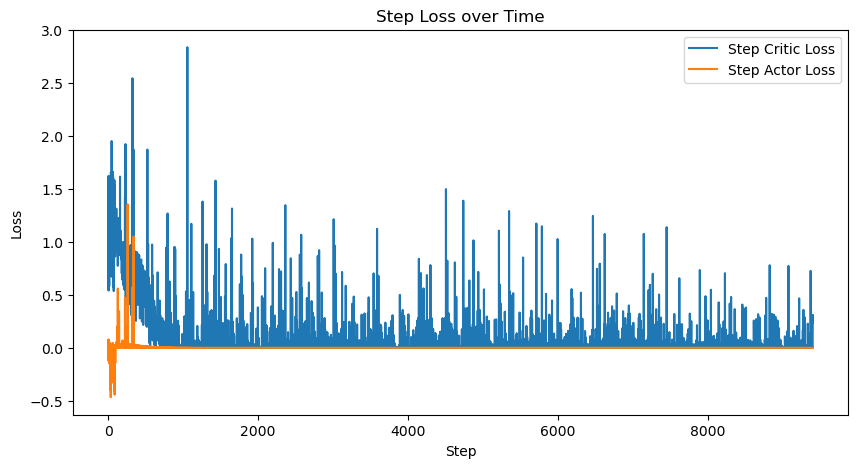

In [5]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        lr = 0.001,
                        gamma = 0.98
                        )
    Manger.train()
    Manger.plotting()

What a terrible result! The policy is not improved at all. What's wrong with it?